<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/Hall/Hall_zeroB_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Hall: Measurements at zero magnetic field


Evgeny Kolonsky 2025

v.0.1.3


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests

# The model with misalignment factor $\beta$

$$
U_H' = U_H + \beta U_p + U_0
\tag{1}
$$
where $U_H'$ is observed voltage measured on the Hall pins of the `PHYWE Hall unit`, $U_H$ is "pure" hall voltage, having zero value at zero magnetic field, $U_p$ is longitudal voltage, measured on longitudal pins of the unit, and $U_0$ is Hall voltage offset, which can be modified with `Uh comp` regulator on the unit, and $\beta$ is misalignment factor, explaining longitudal voltage leak to the Hall contacts of the unit.

At zero magnetic field the measured Hall voltage expected to be a linear function of longitudal voltage with slope $\beta$:
$$
U_H' = \beta U_p + U_0, \quad \text{when}\quad B\equiv 0.
\tag{2}
$$


## Misalignment factor $\beta$ as slope $U_H'(U_p)$ at $B = 0$

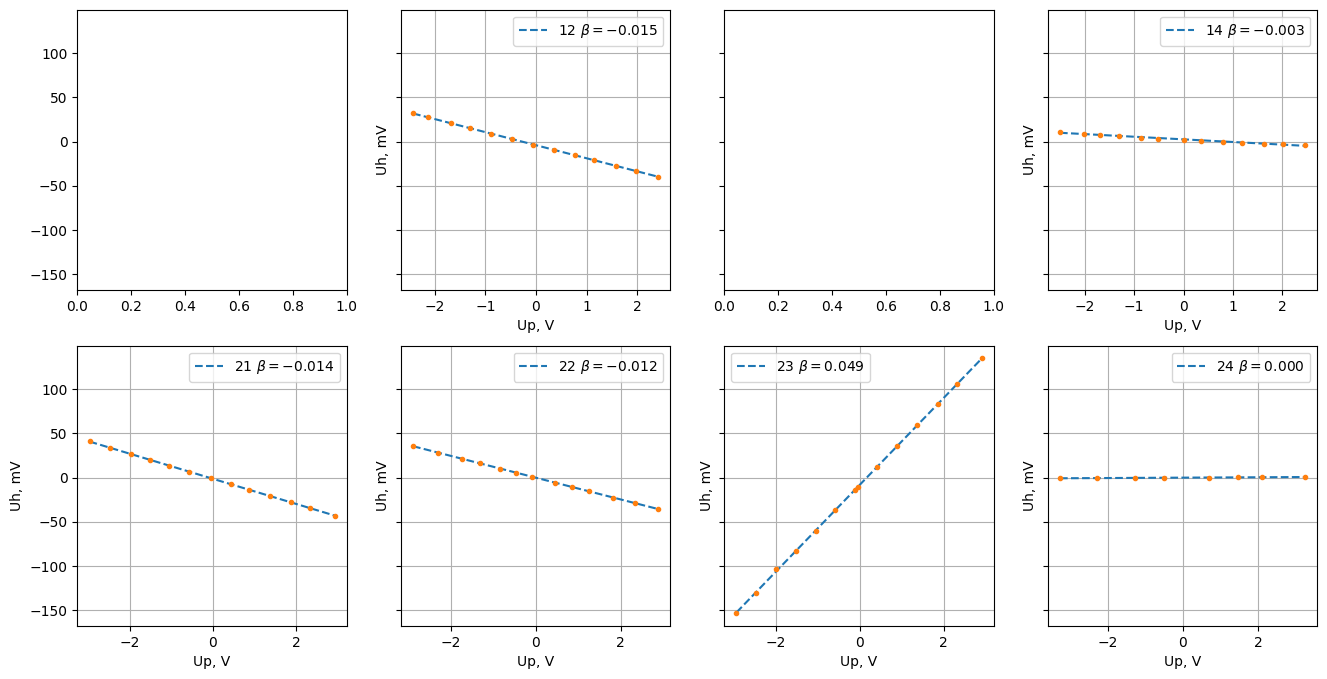

In [2]:
names = ['12',  '14', '21', '22', '23', '24']
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/Hall/zero{name}.txt'
  response = requests.get(url)
  Ip, Up, Uh = np.genfromtxt(response.text.splitlines()).T
  first_digit  = int(name[:2]) % 10
  second_digit = int(name[:2]) // 10
  axx = ax[second_digit-1, first_digit-1]

  axx.set_xlabel('Up, V')
  axx.set_ylabel('Uh, mV')

  fit = linregress(Up, Uh)
  beta = fit.slope
  axx.plot(Up/1000, fit.intercept + fit.slope *Up, '--', label=rf'{name} $\beta ={beta:.3f}$')
  axx.plot(Up/1000, Uh, '.')
  axx.legend()
  axx.grid()
#ax[0,0].remove()
#ax[0,2].remove()




## Longitudal resistance $R$ as slope $U_p(I_p)$

Current $I_p$ is measured with low accuracy, while  potential voltage $U_p$ is measured with high accuracy. We model current as a linear function of potential voltage:
$$
I_p = \frac{1}{R} U_p + I_0.
$$


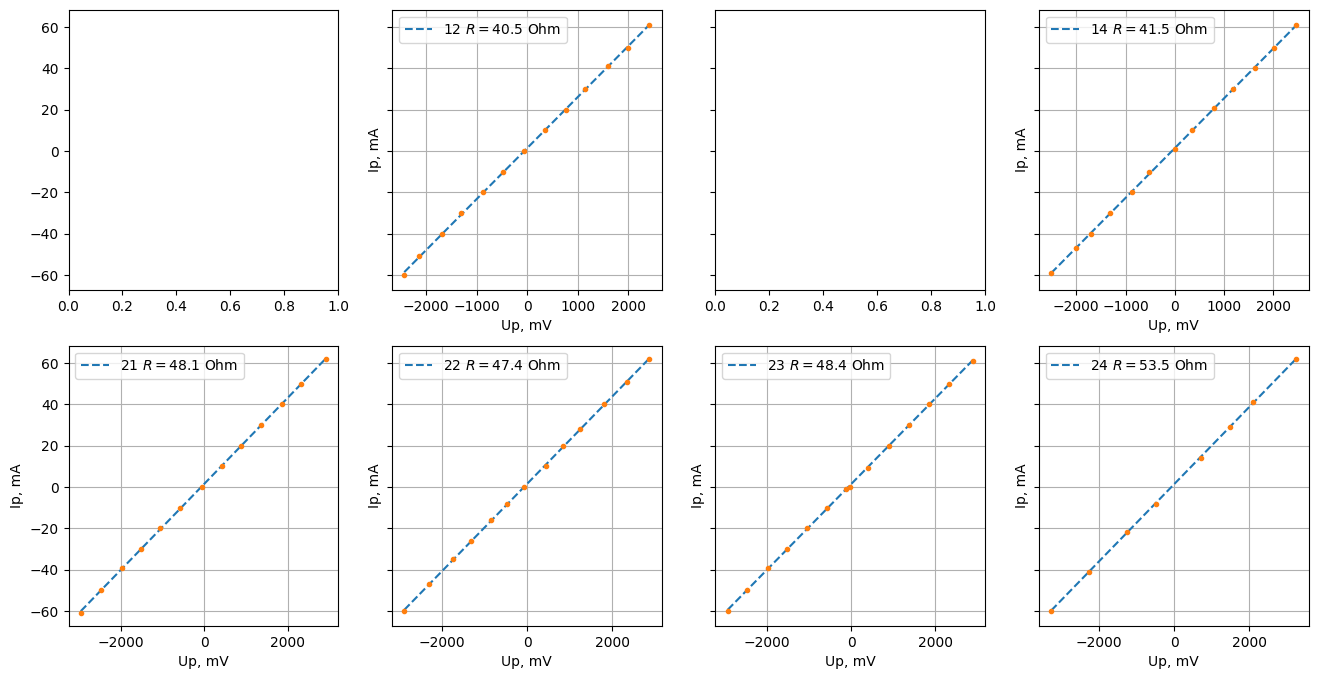

In [3]:
names = ['12',  '14', '21', '22', '23', '24']
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/Hall/zero{name}.txt'
  response = requests.get(url)
  Ip, Up, Uh = np.genfromtxt(response.text.splitlines()).T
  first_digit  = int(name[:2]) % 10
  second_digit = int(name[:2]) // 10
  axx = ax[second_digit-1, first_digit-1]

  axx.set_ylabel('Ip, mA')
  axx.set_xlabel('Up, mV')

  fit = linregress(Up, Ip)
  R = 1/fit.slope
  I0 = fit.intercept
  Ip_fit = fit.intercept + fit.slope *Up
  axx.plot(Up, Ip_fit , '--', label=rf'{name} $R ={R:.1f}$ Ohm')
  axx.plot(Up, Ip , '.')
  axx.legend()
  axx.grid()
#ax[0,0].remove()
#ax[0,2].remove()



# Sample 23. $R_H$ measurements with zero correction

## Step 1. Zero measuremnts at magnetic field $B=0$




### Getting raw data and extracting slopes

/tmp/ipython-input-1682889273.py:20: RuntimeWarning: divide by zero encountered in divide
  Ip_rel = Ip_err / Ip


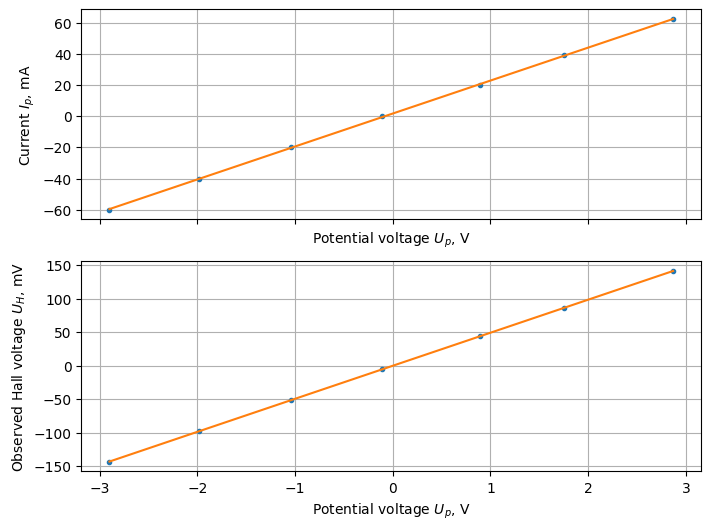

In [43]:
zero = '''
#B = 0
# Ip/mA, Up/mV, Uh/mV
-60 -2900 -143.38
-40 -1983 -97.30
-20 -1046 -51.36
0 -106 -5.25
20 891 43.83
39 1754 86.20
62 2869 141.20
'''

Ip, Up, Uh = np.genfromtxt(zero.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up


fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fit_conductivity = linregress(Up, Ip)
fit_leak = linregress(Up, Uh)
beta, U0 = fit_leak.slope, fit_leak.intercept

ax[0].plot(Up, Ip*1e3, '.')
ax[0].plot(Up, 1e3*(fit_conductivity.intercept + fit_conductivity.slope * Up))
ax[0].set_xlabel(r'Potential voltage $U_p$, V')
ax[0].set_ylabel(r"Current $I_p$, mA")
ax[0].grid()


ax[1].plot(Up, Uh*1e3, '.')
ax[1].plot(Up, (beta*Up + U0)*1e3)
ax[1].set_xlabel(r'Potential voltage $U_p$, V')
ax[1].set_ylabel(r"Observed Hall voltage $U_H$, mV")
ax[1].grid()


## Step 2. Measurements at non-zero magnetic field

$$
R_H = \frac{U_H \cdot d}{B\cdot I_p}
$$

In [16]:
def weighted_average(values, errors):
  weights = 1 / errors**2
  average  = np.sum(weights * values) / np.sum(weights)
  error_of_average = np.sqrt(1 / np.sum(weights))
  return average, error_of_average

In [12]:
d = 1e-3 # mm

### Getting raw data

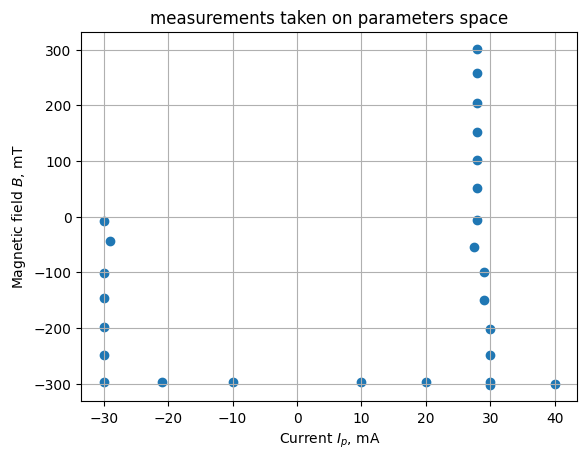

In [48]:
data = '''
# Ip/mA, Up/mV, Uh/mV, B/mT
30 1350 8.89 302
30 1338 17.45 248
30 1329 25.28 202
29 1320 34.67 150
29 1315 44.11 100
27.5 1244 50.60 54
28 1242 59.74 6
28 1242 71.28 -51
28 1244 80.85 -101
28 1250 90.56 -152
28 1257 99.98 -204
28 1265 109.50 -259
28 1272 116.62 -302
40 1854 12.86 300
30 1394 9.89 298
20 894 6.34 297
10 466 3.29 297
#0 -53 -0.33 297
-10 -574 -3.98 297
-21 -1106 -7.77 297
-30 -1521 -10.76 297
-30 -1507 -19.71 248
-30 -1495 -29.23 198
-30 -1485 -39.64 147
-30 -1479 -49.21 101
-29 -1472 -62.14 44
-30 -1470 -70.53 7
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B *= -1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

plt.scatter(Ip*1e3, B*1e3)
plt.xlabel(r'Current $I_p$, mA')
plt.ylabel(r'Magnetic field $B$, mT')
plt.title('measurements on parameters space')
plt.grid()

### Calculating $R_H$ **without** zero correction

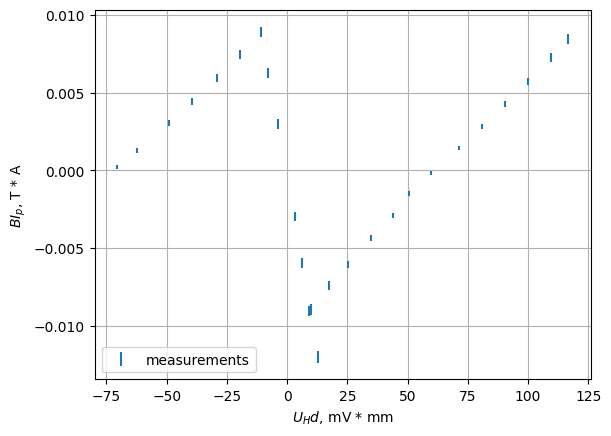

In [17]:
y = B * Ip
# relative error
y_rel = np.sqrt(B_rel**2 + Ip_rel**2)
y_err = np.abs(y * y_rel)
# Error by x is negligible
x = Uh * d

plt.errorbar(x*1e6, y, yerr=y_err, linestyle='', label='measurements')
plt.grid()
plt.ylabel(r'$B I_p$, T * A')
plt.xlabel(r'$U_H d$, mV * mm')
plt.legend()



**Conclusion** data analysis without zero correction is senseless.

### Calculating $R_H$ **with** zero correction

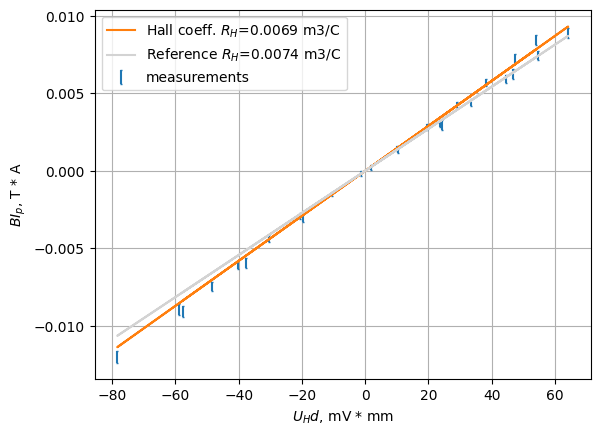

In [41]:
# hall voltage zero correction
Uh_ = Uh - beta * Up - U0


y = B * Ip
# relative error
y_rel = np.sqrt(B_rel**2 + Ip_rel**2)
y_err = np.abs(y * y_rel)
# Error by x is negligible
x = Uh_ * d
k, k_error  = weighted_average(y/x, y_err/x)
k_rel = np.abs(k_error / k)
RH = 1 / k
RH_err =  RH * k_rel

plt.errorbar(x*1e6, y, yerr=y_err,  capsize=1, linestyle='', label='measurements')
plt.plot(x*1e6, (k * x), label=fr'Hall coeff. $R_H$={RH:.4f} m3/C')
plt.grid()
plt.ylabel(r'$B I_p$, T * A')
plt.xlabel(r'$U_H d$, mV * mm')


# reference
RH_ref = 7.37e-3
k_ref = 1/ RH_ref
plt.plot(x*1e6, k_ref*x, label=fr'Reference $R_H$={RH_ref:.4f} m3/C', color='lightgray')

plt.legend()

In [42]:
print(f'Measured value RH = {RH*1e3:.2f} ± {RH_err*1e3:.2f}  m3/C')

Measured value RH = 6.89 ± 0.07  m3/C


### Reference value of the Hall coefficient $R_H$

Reference value $R_H = 7.37 \times 10^{-3} m^3/C$

### Conclusion

Measurements at zero magnetic field should be performed before loading the sample with magnetic field to find true zero and apply zero correction.

Results with zero correction are consistent with the linear model.